In [69]:
import pandas as pd
import numpy as np
from math import sqrt

In [2]:
sales_of_company_x = pd.read_csv("monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("daily-total-female-births-in-cal.csv")

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
M_m_a_t_N_c = mean_monthly_temp["Deg"]

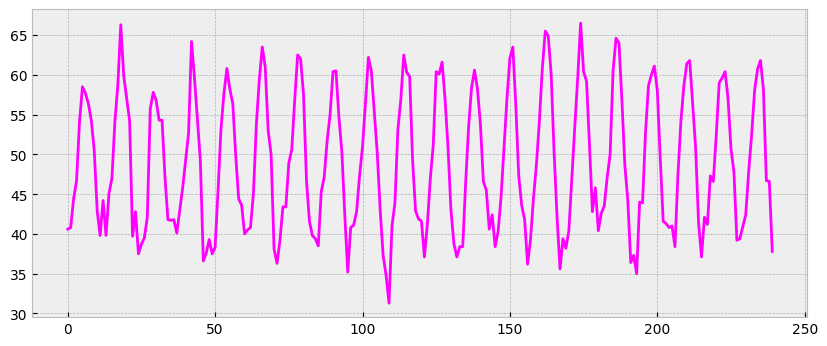

In [29]:
with plt.style.context ('bmh'):
  plt.figure(figsize=(10,4))
  plt.plot(M_m_a_t_N_c, color = 'magenta')

In [ ]:
"""в данном графике отсутствует разброс дисперсии и тренд. сезонность = 12, т.е. ряд не является стационарным.
собираюсь применить скользящее среднее (MA), взвешенное скользящее среднее (WMA) и экспоненциальное скользящее среднее (EMA)"""

In [31]:
def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()

In [32]:
def weighted_moving_average(series, n, weights):
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    wma = series.rolling(n).apply(lambda s: (s * weights).sum() / weights.sum(), raw=True)
    return wma

In [33]:
def exponential_moving_average(series, alpha):
    result = [series[0]]
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return pd.Series(result)

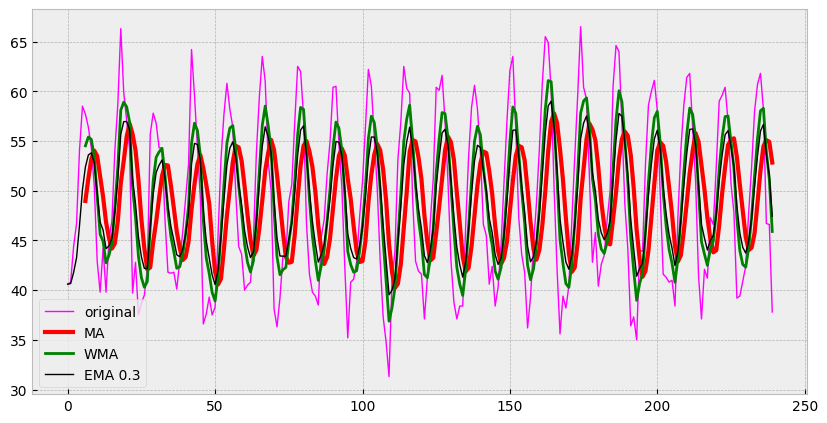

In [42]:
ema = exponential_moving_average(M_m_a_t_N_c, 0.3)
wma = weighted_moving_average(M_m_a_t_N_c, 7, [1,1,2,3,5,8,13])
ma = moving_average(M_m_a_t_N_c, 7)
with plt.style.context('bmh'):
    plt.figure(figsize=(10, 5))
    plt.plot(M_m_a_t_N_c, color='magenta', linewidth='1', label='original')
    plt.plot(ma, color='red', linewidth='3', label='MA')
    plt.plot(wma, color='green', linewidth='2', label='WMA')
    plt.plot(ema, color='black', linewidth='1', label='EMA 0.3')
    plt.legend()

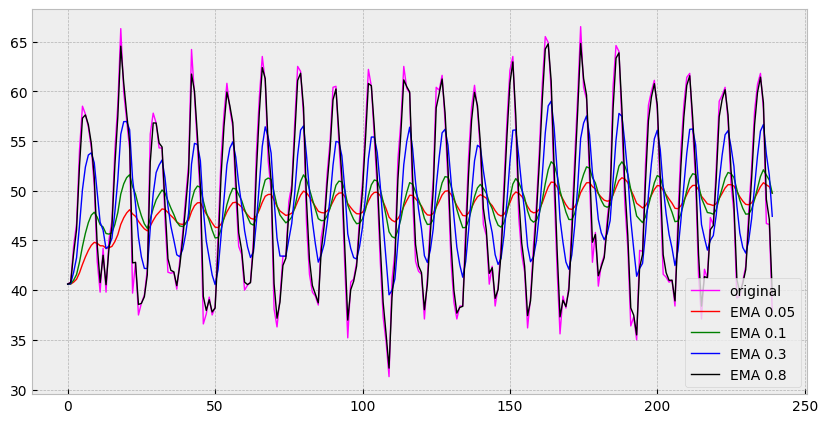

In [43]:
alphas = [0.05, 0.1, 0.3, 0.8]
colors = ['red', 'green', 'blue', 'black']
with plt.style.context('bmh'):
    plt.figure(figsize=(10, 5))
    plt.plot(M_m_a_t_N_c, color='magenta', linewidth='1', label='original')
    for i in range(len(alphas)):
        ser_ema = exponential_moving_average(M_m_a_t_N_c, alphas[i])
        plt.plot(ser_ema, color=colors[i], linewidth='1', label='EMA {}'.format(alphas[i]))
    plt.legend()

In [ ]:
"""ближе всего проходит график, где альфа=0.8. т.к. в ряде присутствует сезонность можно попробовать применить метод Хольта-Винтерса(TEMA) и сравнить результат"""

In [ ]:
# тренд
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [44]:
# тренд исправленный
def initial_trend2 (series, season_len):
    sum = 0.0
    for i in range(season_len):
      sum += float(series[i+season_len] - series[i]) / season_len
    return sum / season_len

In [45]:
# сезонность
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [46]:
# тройное экспоненциальное сглаживание
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend2(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [63]:
# функция отображения графика TEMA при заданных значениях альфа, бета и гамма
def plot_tema(alpha, beta, gamma, ser_tema=M_m_a_t_N_c, ser_to_plot=M_m_a_t_N_c, n_preds=24):
    tema = triple_exponential_smoothing(M_m_a_t_N_c, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(10, 5))
        plt.plot(ser_to_plot, color='blue', linewidth='2', label='original')
        plt.plot(tema, color='red', linewidth='1', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

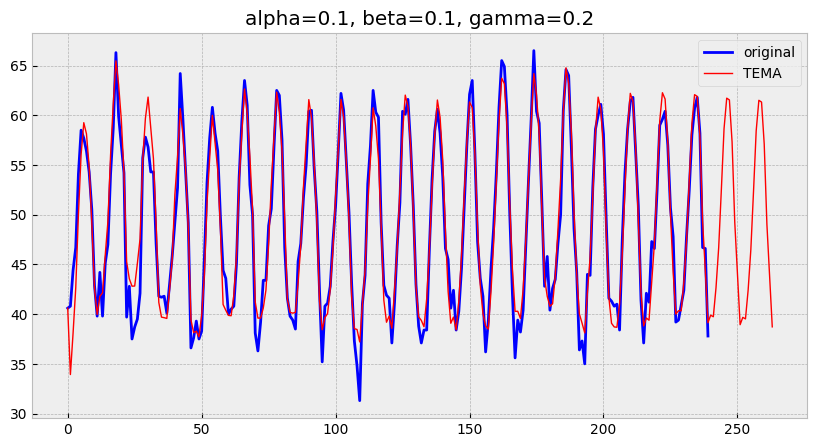

In [64]:
plot_tema(0.1, 0.1, 0.2)

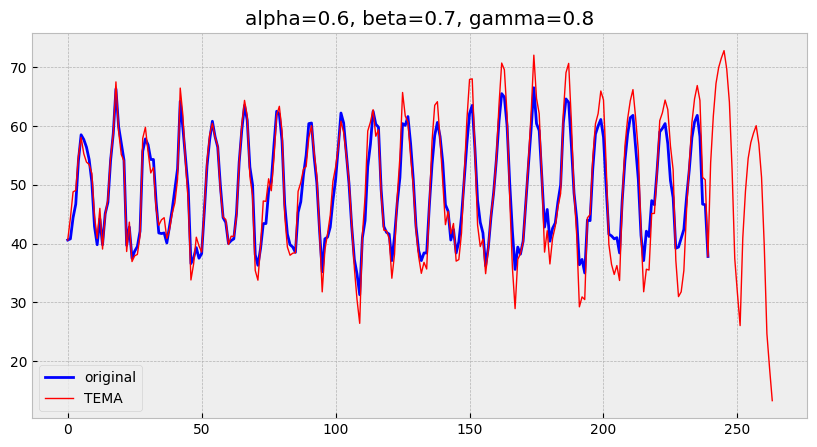

In [65]:
plot_tema(0.6, 0.7, 0.8)

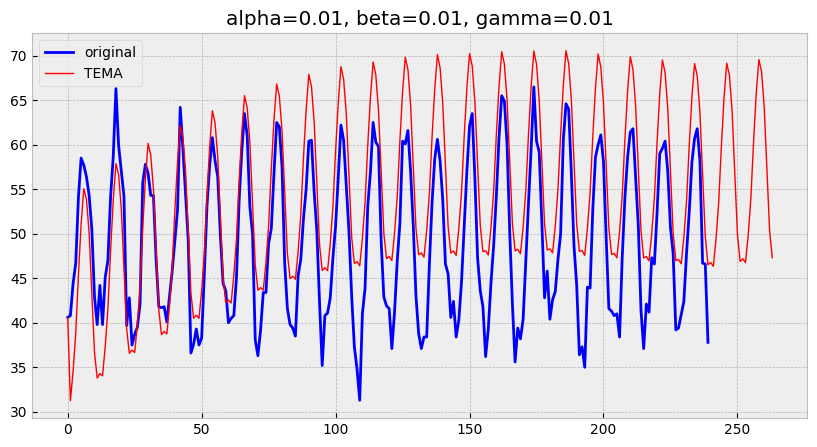

In [66]:
plot_tema(0.01, 0.01, 0.01)

In [ ]:
"""метод ТЕМА тоже хорошо работает при определенных параметрах, как и EMA c альфа = 0.8.
при помощи RMSE подберу лучшие параметры альфа, бета и гамма. """

In [54]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [55]:
len(M_m_a_t_N_c)

240

In [57]:
train, test, val = M_m_a_t_N_c[:200], M_m_a_t_N_c[200:230], M_m_a_t_N_c[230:]

In [58]:
def mse(X):
    alpha, beta, gamma = X
    result = triple_exponential_smoothing(train, 12, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [59]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [60]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 3.4424522704394644
        x: [ 9.237e-01  4.716e-02  8.027e-01]
      nit: 36
      jac: [ 5.107e-06  9.148e-06 -1.732e-06]
     nfev: 188
     njev: 47
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


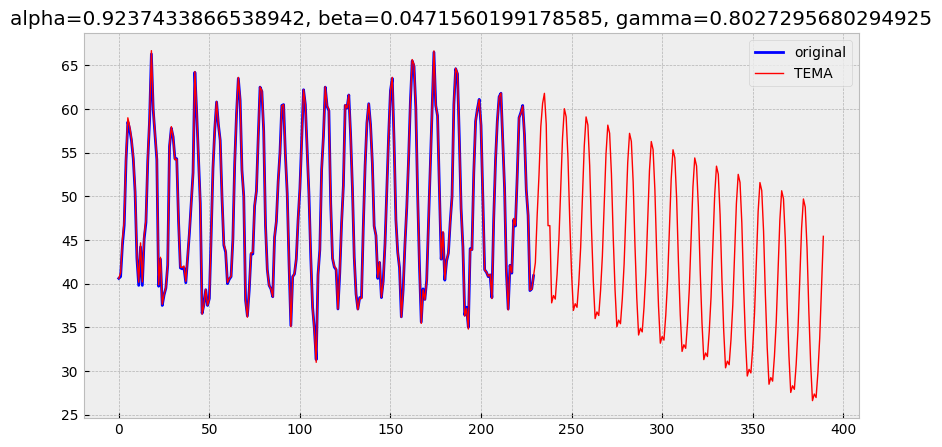

In [67]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser_tema=train, ser_to_plot=M_m_a_t_N_c[:230], n_preds=len(test)*5)

In [70]:
# RMSE это квадратный корень из MSE
print(sqrt(mse((alpha_opt, beta_opt, gamma_opt))))

1.8553846691291442


In [ ]:
#кросс-валидация

In [71]:
train, val = M_m_a_t_N_c[:230], M_m_a_t_N_c[230:]

In [72]:
from sklearn.model_selection import TimeSeriesSplit

def mse_cross_val(X):
    alpha, beta, gamma = X
    split = TimeSeriesSplit(n_splits=3)
    errors = []

    for train_split, test_split in split.split(train):
        train_split_ts = train.iloc[train_split]
        test_split_ts = train.iloc[test_split]
#         print(train_split_ts)
#         print(test_split_ts)
        result = triple_exponential_smoothing(train_split_ts, 12, alpha, beta, gamma, len(test_split))
        predictions = result[-len(test_split_ts):]
        error = mean_squared_error(predictions, test_split_ts)
        errors.append(error)
    print(f'{np.mean(np.array(errors))}------------')
    return np.mean(np.array(errors))


In [73]:
opt = minimize(mse_cross_val, x0=[0,0,0], method = "L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

241.1155109709936------------
241.11538232996315------------
241.11551097099013------------
241.11550025320898------------
52.71136484984896------------
52.71136469320792------------
52.71134250089094------------
52.71136484984896------------
384.6832807698384------------
384.6832750211579------------
384.68331379135344------------
384.6832807698384------------
49.42954703680156------------
49.42954649176948------------
49.429553716922506------------
49.42954703680156------------
45.18591871529822------------
45.18591915823287------------
45.18592295632112------------
45.18591871518202------------
42.490449604160254------------
42.490449890068405------------
42.490448731481756------------
42.49044960468117------------
42.369546217014864------------
42.36954652413636------------
42.369546416111056------------
42.36954621777682------------
42.27454309107791------------
42.27454339561297------------
42.27454333326516------------
42.274543092280574------------
41.90572851229628------------

In [74]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 7.863149615901381
        x: [ 8.524e-02  5.257e-02  0.000e+00]
      nit: 30
      jac: [ 1.243e-05  3.090e-04  4.272e-01]
     nfev: 192
     njev: 48
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


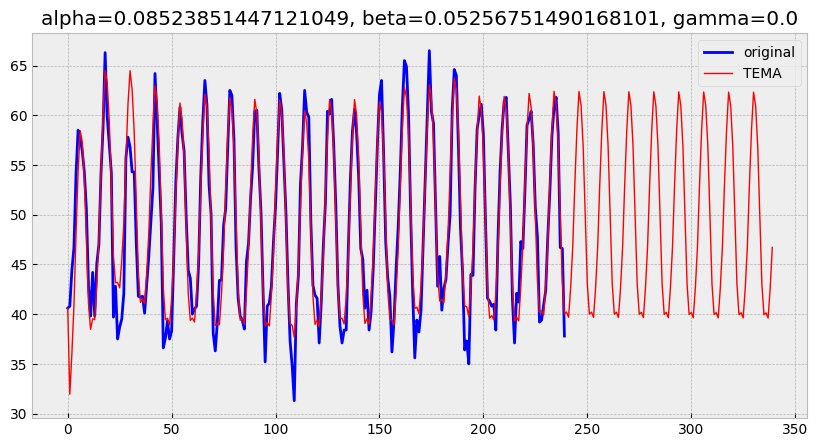

In [75]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser_tema=train, ser_to_plot=M_m_a_t_N_c, n_preds=len(val)*10)

In [76]:
# рассчитаем RMSE на кросс-валидации
print(sqrt(mse((alpha_opt, beta_opt, gamma_opt))))

16.20439516225555


In [ ]:
#RMSE на кросс-валидации (16.2) получилась выше, чем без кросс-валидации (1.855)

Вывод: применение TEMA позволило хорошо предсказать сезонность, но ошибка получилась очень большая. Экспоненциальное сглаживание (EMA) c альфа (коэфф-том сглаживания), =0.8 показало хороший результат.
Попробую сделать ряд стационарным, затем применить к нему TEMA и рассчитать RMSE.

In [77]:
M_m_a_t_N_c_diff = np.diff(M_m_a_t_N_c, 12) #убрала сезонность

In [78]:
from statsmodels.tsa.stattools import adfuller

In [79]:
################
 # Dickey-Fuller
##################
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [83]:
test_stationarity(M_m_a_t_N_c_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.672894e+01
p-value                        1.388342e-29
#Lags Used                     1.500000e+01
Number of Observations Used    2.120000e+02
Critical Value (1%)           -3.461578e+00
Critical Value (5%)           -2.875272e+00
Critical Value (10%)          -2.574089e+00
dtype: float64


In [ ]:
# тест Дики-Фуллера показал, что p-value= 0.00 это значит, что ряд стал стационарным

In [84]:
len(M_m_a_t_N_c_diff)

228

In [97]:
train, test, val = M_m_a_t_N_c_diff[:200], M_m_a_t_N_c_diff[200:220], M_m_a_t_N_c_diff[220:]

In [98]:
opt = minimize(mse, x0=[0,0,0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

In [99]:
alpha_opt, beta_opt, gamma_opt = opt.x
print(opt)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 8275169.488560177
        x: [ 7.030e-04  1.000e+00  1.816e-01]
      nit: 49
      jac: [ 5.519e+02 -5.263e+02 -6.706e+00]
     nfev: 296
     njev: 74
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


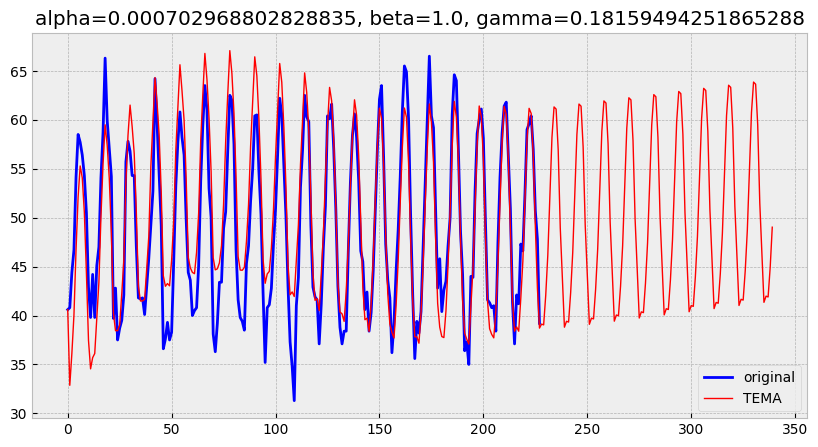

In [100]:
plot_tema(alpha_opt, beta_opt, gamma_opt, ser_tema=train, ser_to_plot=M_m_a_t_N_c[:228], n_preds=len(test)*5)

In [101]:
# рассчитаем RMSE на TEMA со стационарным рядом
print(sqrt(mse((alpha_opt, beta_opt, gamma_opt))))

2876.659432146979


RMSE показывает какую-то нереально высокую цифру по сравнению с кросс-валидацией/TEMA(16.20), и гораздо больше, чем на нестационарном ряде без кросс-валидации(1.85). Также появился тренд, которого вообще не было.

Вывод: TEMA не подходит для предсказания значений стационарного ряда (даже не пришлось приводить ряд к стационарному виду).